In [1]:
################################################
#### Jingying Wang <astro.jywang@gmail.com> ####
###############################################
#imports
import katdal
import numpy as np
import matplotlib.pylab as plt
import astropy.coordinates as ac
import functools
import healpy as hp
import optparse
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import healpy as hp
from astropy import units as u
from matplotlib.offsetbox import AnchoredText
import time
import pickle
import sys
Tcmb=2.725
import katcali
import katcali.visualizer as kv
import katcali.models as km
import katcali.rfi as kr
import katcali.solver as ks
import katcali.io as kio
import katcali.label_dump as kl
import katcali.diode as kd
import katcali.filter as kf                                                                                                                                                                                                                  
from astropy.coordinates import SkyCoord
from astropy import units as u

print (katcali.__version__)

2.0.0


In [2]:
import faulthandler
faulthandler.enable()

In [3]:
print (katdal.__version__)

0.20.1


In [4]:
print ('start @ ' + time.asctime(time.localtime(time.time())) +'#')


start @ Fri Dec 23 07:04:05 2022#


In [5]:
print  (plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'])
plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 14, 1.5, 1.5
#plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 10.0, 0.8, 1.5
print  (plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'])

10.0 0.8 1.5
14.0 1.5 1.5


In [6]:
#fname='1640712986'#zebra shift, Marta
#fname='1633970780'#nest
#fname='1634748682'#lightning
fname='1638898468'#"a zebra hitting a wall"
data=kio.load_data(fname)
#print (data)

In [7]:
target,c0,bad_ants,flux_model=kio.check_ants(fname)


calibrator: PictorA, ra,dec= 79d57m25.8149s, -45d46m43.7801s
bad_ants: ['m036']


In [8]:
ants_good=[]
for i in np.array(kio.ant_list(data)):
    if i not in bad_ants:
        ants_good.append(i)
    else:
        print (str(i) + ' is bad')
print (fname)
print (ants_good)

m036 is bad
1638898468
['m000', 'm001', 'm002', 'm003', 'm004', 'm005', 'm006', 'm007', 'm008', 'm009', 'm010', 'm011', 'm012', 'm013', 'm014', 'm015', 'm016', 'm017', 'm018', 'm019', 'm020', 'm021', 'm022', 'm023', 'm024', 'm026', 'm027', 'm028', 'm029', 'm030', 'm031', 'm032', 'm033', 'm034', 'm035', 'm037', 'm038', 'm039', 'm040', 'm042', 'm043', 'm044', 'm045', 'm046', 'm047', 'm048', 'm049', 'm050', 'm051', 'm053', 'm055', 'm056', 'm057', 'm058', 'm059', 'm060', 'm061', 'm062', 'm063']


In [9]:
nd_on_time,nd_cycle,nd_set=kd.cal_nd_basic_para(fname)
print (nd_on_time,nd_cycle,nd_set)

0.584752616075 19.4917538692 1638898468.77


# Select ant and polarization, then load data in 

In [10]:
#select ant, polarization, and one channel to show data calibration
ant='m003'
pol='h'

ch_plot=800


In [11]:
#load data, labels, and parameters
ch_ref=800
data.select(ants=ant,pol=pol)
recv=ant+pol
corr_id=kio.cal_corr_id(data,recv)
assert(recv==data.corr_products[corr_id][0])
assert(recv==data.corr_products[corr_id][1])
print (corr_id,recv)

0 m003h


In [12]:
ra,dec,az,el=kio.load_coordinates(data)
timestamps,freqs=kio.load_tf(data)
dump_period=data.dump_period


In [13]:
vis,flags= kio.call_vis(fname,recv)
ang_deg=kio.load_ang_deg(ra,dec,c0)


# loaded data was saved in python2
['m003h' 'm003h']


In [14]:
dp_tt,dp_ss,dp_f,dp_w, dp_t,dp_s,dp_slew,dp_stop=kl.cal_dp_label(data,flags,ant,pol,ch_ref,ang_deg)

ra1=ra.copy()
for i in range(len(ra)):
    if ra[i]>180:
        ra1[i]=ra[i]-360

nd_on_edge,nd_off_edge=kd.cal_nd_edges(timestamps,nd_set,nd_cycle,nd_on_time)
print (len(nd_on_edge),len(nd_off_edge))

nd_ratio,nd_0, nd_1x=kd.cal_nd_ratio(timestamps, nd_on_time, nd_on_edge, dump_period)

nd_t0,nd_t1x,nd_s0,nd_s1x,nd_t0_ca,nd_t0_cb,nd_t1x_ca,nd_t1x_cb=kl.cal_label_intersec(dp_tt,dp_ss,nd_0,nd_1x)

edge number 0-391
392 392
*** diode 0 was fired out of timestamps list: -112.10961294174194 not in [0,7522.81741642952]
*** diode 1 was fired out of timestamps list: -92.61785912513733 not in [0,7522.81741642952]
*** diode 2 was fired out of timestamps list: -73.12610530853271 not in [0,7522.81741642952]
*** diode 3 was fired out of timestamps list: -53.63435125350952 not in [0,7522.81741642952]
*** diode 4 was fired out of timestamps list: -34.14259743690491 not in [0,7522.81741642952]
*** diode 5 was fired out of timestamps list: -14.650843620300293 not in [0,7522.81741642952]
# checked: len(nd_0)+len(nd_1x)==len(timestamps)


## Check the final mask 
## (mask_h and mask_v are both required)

In [15]:
#get vis
recv1=ant+'h'
recv2=ant+'v'

In [16]:
vis_h,flags_h= kio.call_vis(fname,recv1)
vis_v,flags_v= kio.call_vis(fname,recv2)
vis_clean_h=np.ma.array(vis_h,mask=flags_h)
vis_clean_v=np.ma.array(vis_v,mask=flags_v)

# loaded data was saved in python2
['m003h' 'm003h']
# loaded data was saved in python2
['m003v' 'm003v']


In [17]:
ch_plot_list=[600,800,1000,2200,2400,2600,2800,3000]
plot_gsize=90

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


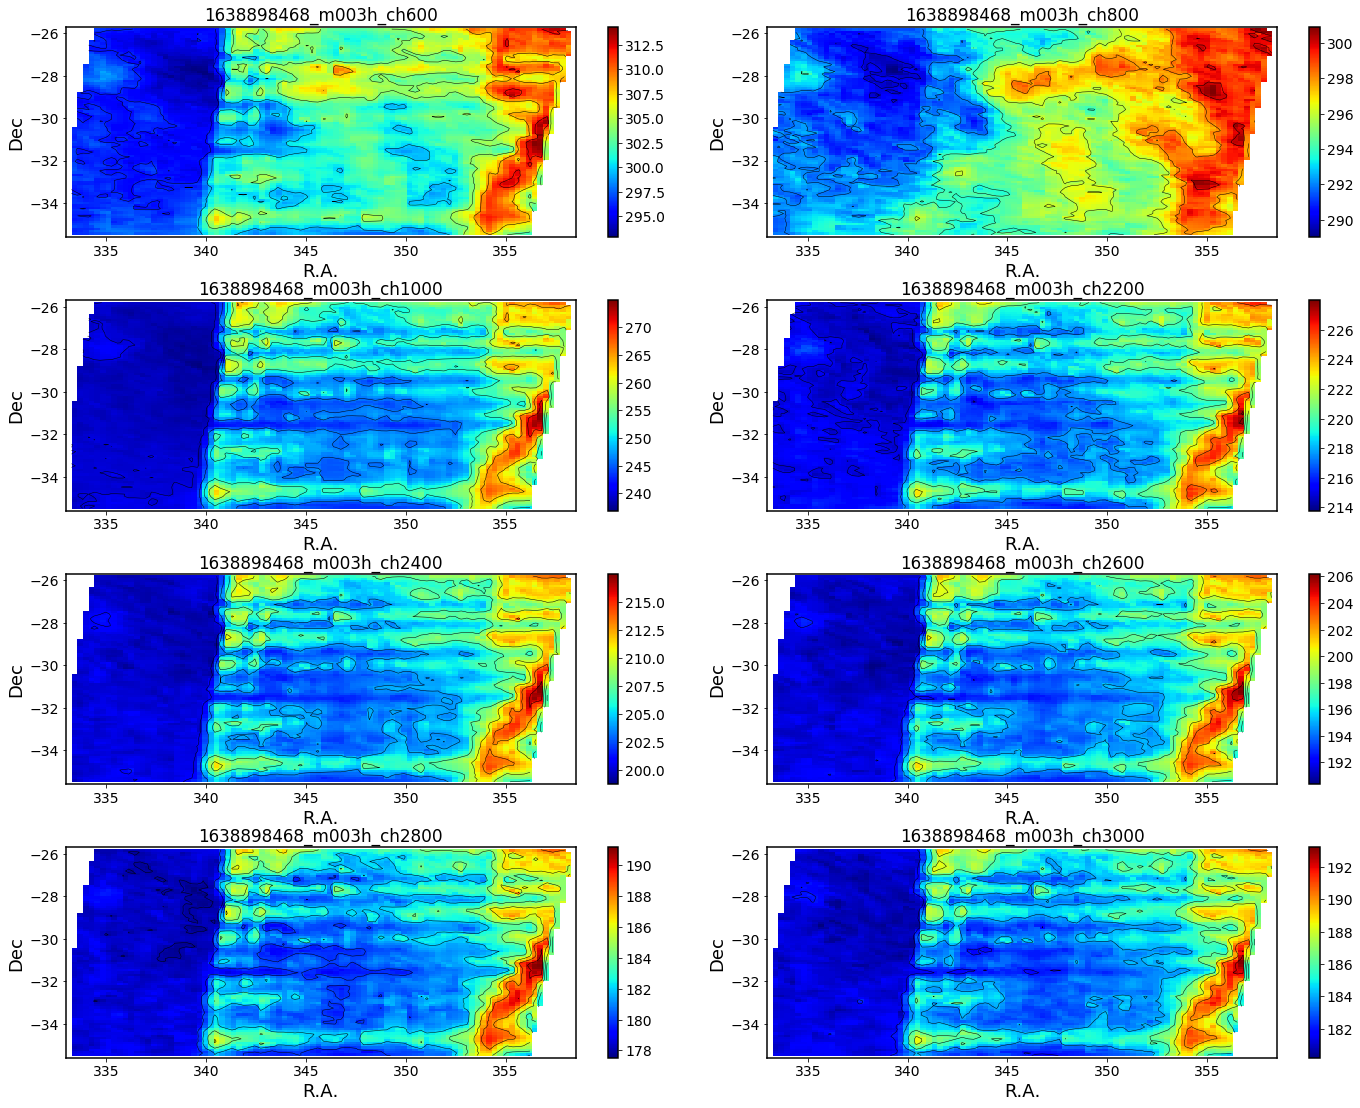

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


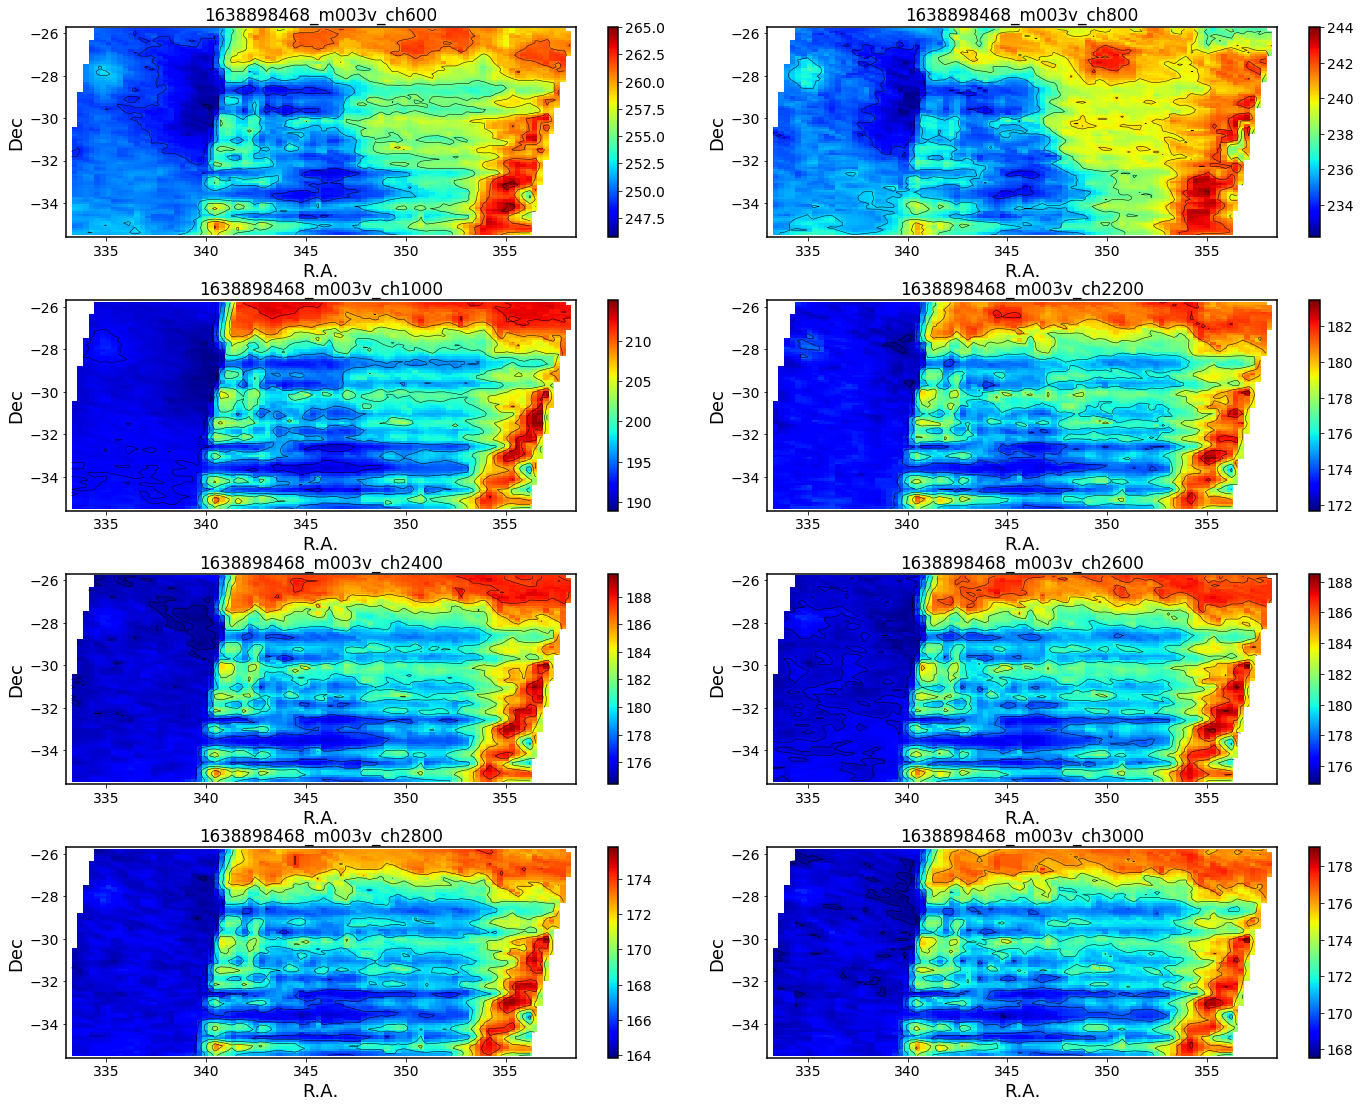

In [18]:
for pol in ['h','v']:
    recv=ant+pol
    if pol=='h':
        vis_clean_pol=vis_clean_h
    if pol=='v':
        vis_clean_pol=vis_clean_v
        
    plt.figure(figsize=(24,24))
    plt.subplots_adjust(wspace =0.1, hspace=0.3)
    for i in range(len(ch_plot_list)):
        ch_plot1=ch_plot_list[i]
        p_data=vis_clean_pol[nd_s0,ch_plot1]
        plt.subplot(5,2,i+1)
        #kv.plot_data(ra[nd_s0],dec[nd_s0], p_data,gsize=60)
        kv.plot_mdata(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize,  grid_method='linear', levels=6, x_mask=1, y_mask=2)
        #plt.plot(p_radec[:,0],p_radec[:,1],'mo')
        #if i>len(ch_plot_list)-3:
        plt.xlabel('R.A.',fontsize=18)
        plt.ylabel('Dec',fontsize=18)
        plt.title(fname+'_'+recv+'_ch'+str(ch_plot1))
        #plt.plot(p_radec[:,0],p_radec[:,1],'mo')
    #plt.savefig(output_file+fname+'_'+recv+'_map.png')
    plt.show()

In [19]:
# RFI flagging

input_file='/idia/projects/hi_im/raw_vis/MeerKLASS2021/level1/mask/'

try:
    d3 = pickle.load(open(input_file+fname+'_'+ant+'_mask2', 'rb'))
    print ('mask2 loaded')
except(Exception):
    d3 = pickle.load(open(input_file+fname+'_'+ant+'_mask', 'rb'))
    print ('mask loaded')

mask_inter=d3['mask']


mask loaded


In [20]:
#update vis_clean
vis_clean_hh=np.ma.array(vis_clean_h,mask=mask_inter)
vis_clean_vv=np.ma.array(vis_clean_v,mask=mask_inter)


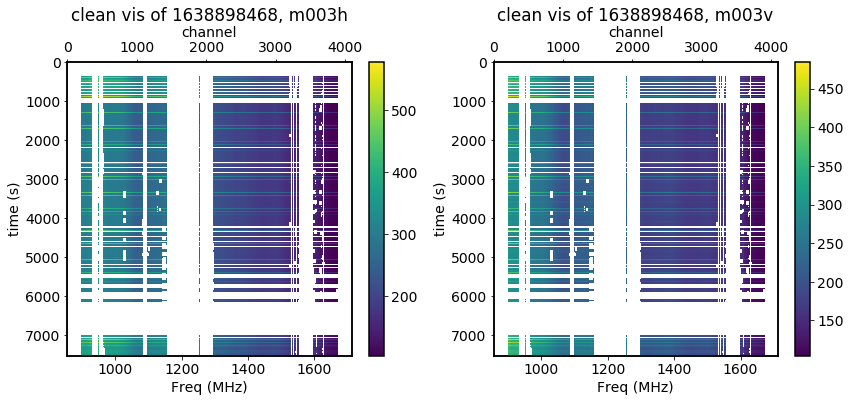

In [21]:
plt.figure(figsize=(14,5.4))
plt.subplot(121)

plt.imshow(vis_clean_hh,aspect='auto',extent=(data.freqs[0]/1e6,data.freqs[-1]/1e6,len(timestamps)*2,0))
plt.xlabel('Freq (MHz)')
plt.ylabel('time (s)')

plt.title('clean vis of '+str(fname)+', '+str(ant)+'h', y=1.12)
plt.colorbar()
plt.twiny()
plt.imshow(vis_clean_hh,aspect='auto',extent=(0,len(data.freqs),len(timestamps)*2,0))
plt.xlabel('channel')

plt.subplot(122)

plt.imshow(vis_clean_vv,aspect='auto',extent=(data.freqs[0]/1e6,data.freqs[-1]/1e6,len(timestamps)*2,0))
plt.xlabel('Freq (MHz)')
plt.ylabel('time (s)')

plt.title('clean vis of '+str(fname)+', '+str(ant)+'v', y=1.12)
plt.colorbar()
plt.twiny()
plt.imshow(vis_clean_vv,aspect='auto',extent=(0,len(data.freqs),len(timestamps)*2,0))
plt.xlabel('channel')

#plt.savefig(str(fname)+'raw_vis.pdf', bbox_inches='tight')
#plt.savefig(output_file+str(fname)+'_'+ant+'_clean_vis.png', bbox_inches='tight')
plt.show()


In [22]:
#show channel changes

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


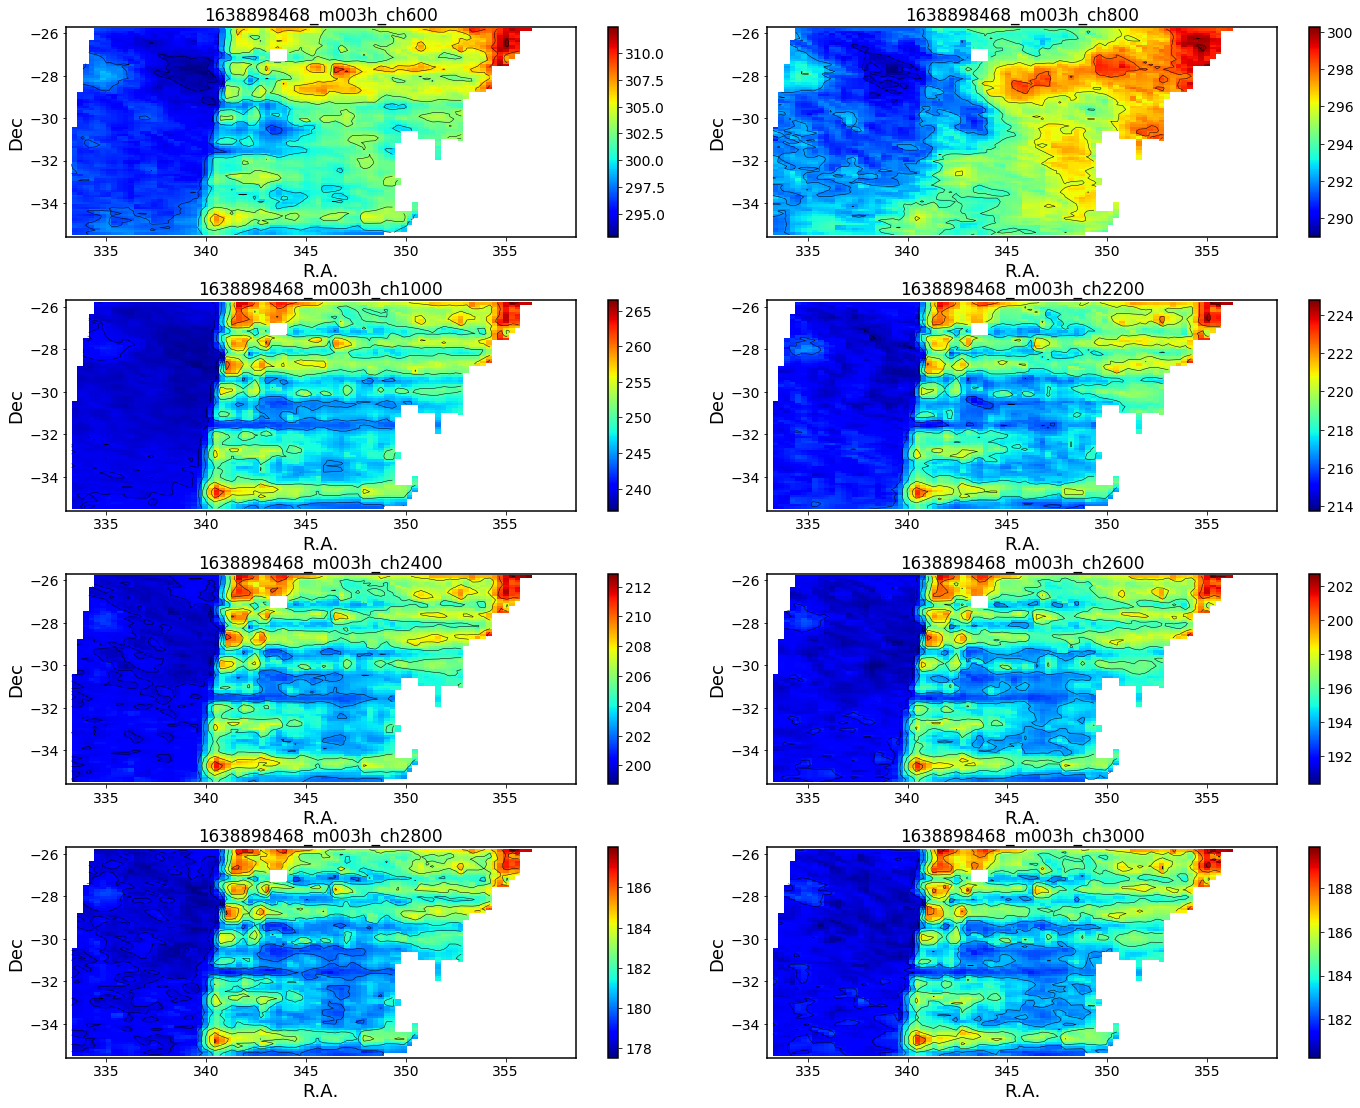

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


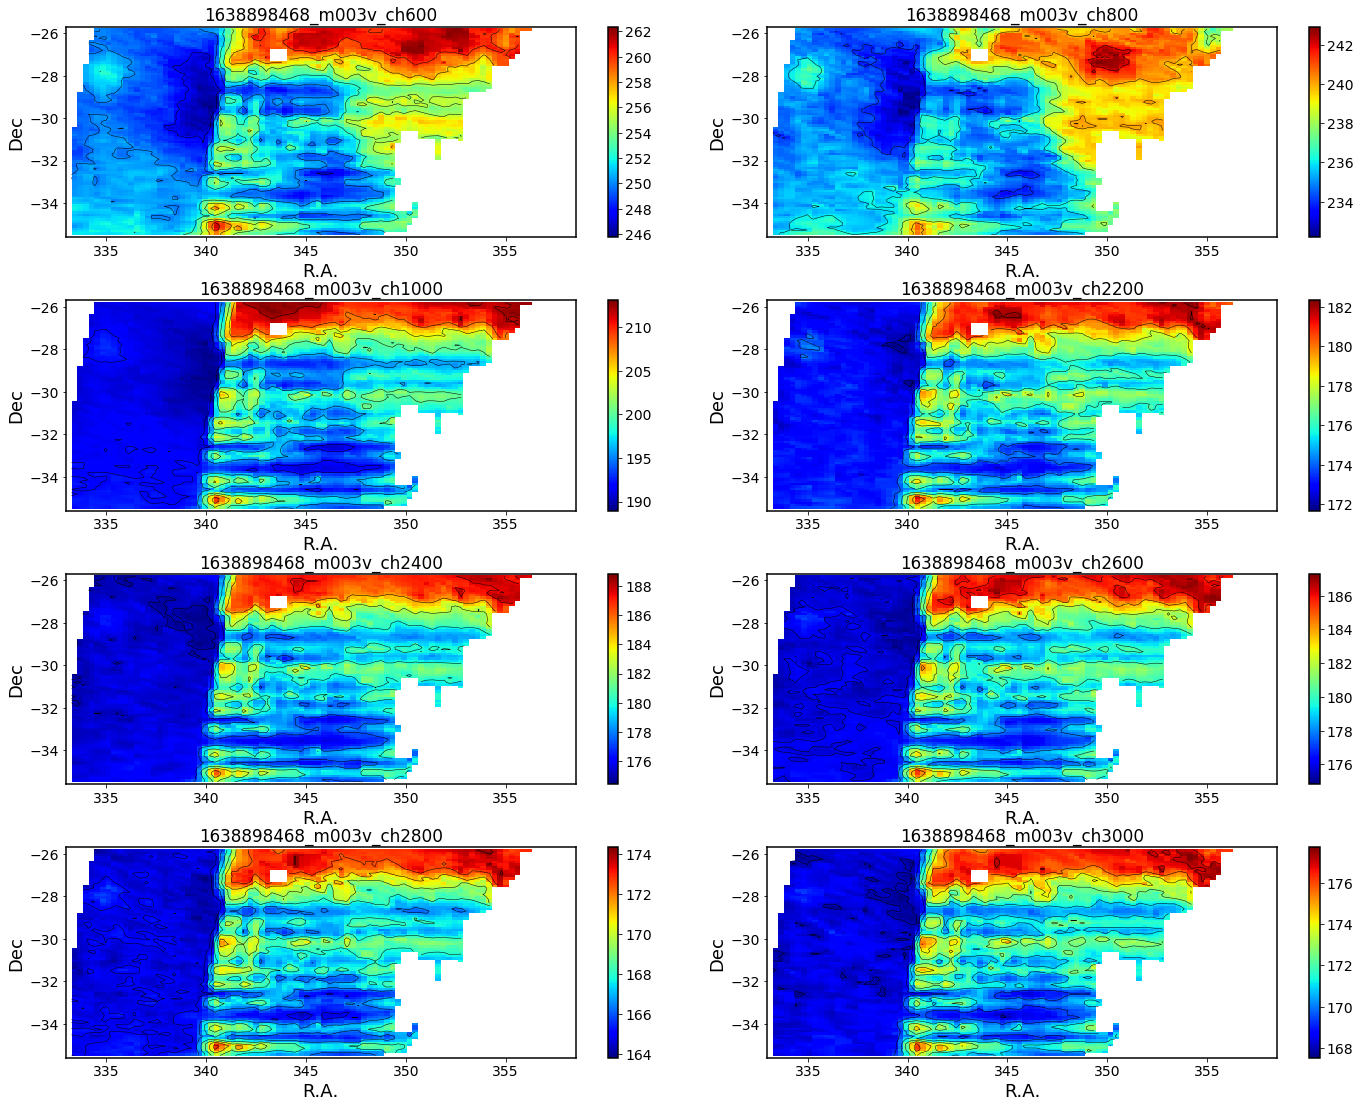

In [23]:
for pol in ['h','v']:
    recv=ant+pol
    if pol=='h':
        vis_clean_pol=vis_clean_hh
    if pol=='v':
        vis_clean_pol=vis_clean_vv
        
    plt.figure(figsize=(24,24))
    plt.subplots_adjust(wspace =0.1, hspace=0.3)
    for i in range(len(ch_plot_list)):
        ch_plot1=ch_plot_list[i]
        p_data=vis_clean_pol[nd_s0,ch_plot1]
        plt.subplot(5,2,i+1)
        #kv.plot_data(ra[nd_s0],dec[nd_s0], p_data,gsize=60)
        kv.plot_mdata(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize,  grid_method='linear', levels=6, x_mask=1, y_mask=2)
        #plt.plot(p_radec[:,0],p_radec[:,1],'mo')
        #if i>len(ch_plot_list)-3:
        plt.xlabel('R.A.',fontsize=18)
        plt.ylabel('Dec',fontsize=18)
        plt.title(fname+'_'+recv+'_ch'+str(ch_plot1))
        #plt.plot(p_radec[:,0],p_radec[:,1],'mo')
    #plt.savefig(output_file+fname+'_'+recv+'_map.png')
    plt.show()

In [24]:
#END of Level 1 

In [25]:
print ('end @ ' + time.asctime(time.localtime(time.time())) +'#')

end @ Fri Dec 23 07:04:33 2022#


In [26]:
kio.cal_freq(490)/1e6

958.40234375